In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import where
from numpy import meshgrid
from numpy import arange
from numpy import hstack
from numpy import std
from numpy import mean

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

import warnings
warnings.simplefilter('ignore')

# Functions for further uses

In [2]:
# Evaluation using cross validation
def eval_cv(classifier, metric):
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # evaluate model
    scores = cross_val_score(classifier, X, y, scoring=metric, cv=cv, n_jobs=-1)
    # report performance
    return mean(scores)

In [3]:
# Calculate the metrics
def calculate_metrics(df, method):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 16})
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    df.loc[method] = [accuracy, precision, recall, f1, auc]

In [4]:
# Do the the cross validation of all metrics
def calculate_cv(df, classifier, method):
    accuracy = eval_cv(classifier, 'accuracy')
    precision = eval_cv(classifier, 'precision')
    recall = eval_cv(classifier, 'recall')
    f1 = eval_cv(classifier, 'f1')
    auc = eval_cv(classifier, 'roc_auc')
    df.loc[method] = [accuracy, precision, recall, f1, auc]    

# Data import and basic exploration

In [5]:
#Importing the dataset
dataset = pd.read_csv(r'D:\Jacobs\Lecture\PTM\Sources\2021\Classification\Datasets\Action_of_offer.csv')
dataset

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [6]:
# Find missing values
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_value_df = pd.DataFrame({'column_name': dataset.columns,
                                 'percent_missing': percent_missing})
display(missing_value_df)

,column_name,percent_missing
User ID,User ID,0.0
Gender,Gender,0.0
Age,Age,0.0
EstimatedSalary,EstimatedSalary,0.0
Purchased,Purchased,0.0


In [7]:
# Count unique values of all categorical columns
categorical_cols = ['Gender','Purchased']
cat_cols_unique_counts_df = pd.DataFrame(columns = ['UniqueValuesCount'], index = categorical_cols)
for col in categorical_cols:
    cat_cols_unique_counts_df.loc[col] = dataset[col].nunique()
display(cat_cols_unique_counts_df)

,UniqueValuesCount
Gender,2
Purchased,2


# Preprocessing

In [8]:
# for columns having unique values > 2, do one hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
ohe_cols = []
ohe = OneHotEncoder()
ct = make_column_transformer(
     (ohe, ohe_cols),
    remainder = 'passthrough'
)
ct.fit_transform(dataset)
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)


# one hot encode columns
for col in ohe_cols:
    dataset = encode_and_bind(dataset, col)

for col in ohe_cols:
    del dataset[col]
display(dataset)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [9]:
# for columns having unique values = 2, do label encoding
from sklearn.preprocessing import LabelEncoder
le_cols =  ['Gender']
le = LabelEncoder()
for col in le_cols:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])
display(dataset)

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,1,19,19000,0
1,15810944,1,35,20000,0
2,15668575,0,26,43000,0
3,15603246,0,27,57000,0
4,15804002,1,19,76000,0
...,...,...,...,...,...
395,15691863,0,46,41000,1
396,15706071,1,51,23000,1
397,15654296,0,50,20000,1
398,15755018,1,36,33000,0


In [10]:
# delete unecessary columns
unecessary_cols = ['User ID']
for col in unecessary_cols:
    del dataset[col]

# Exploratory Data Analysis

<Figure size 720x720 with 0 Axes>

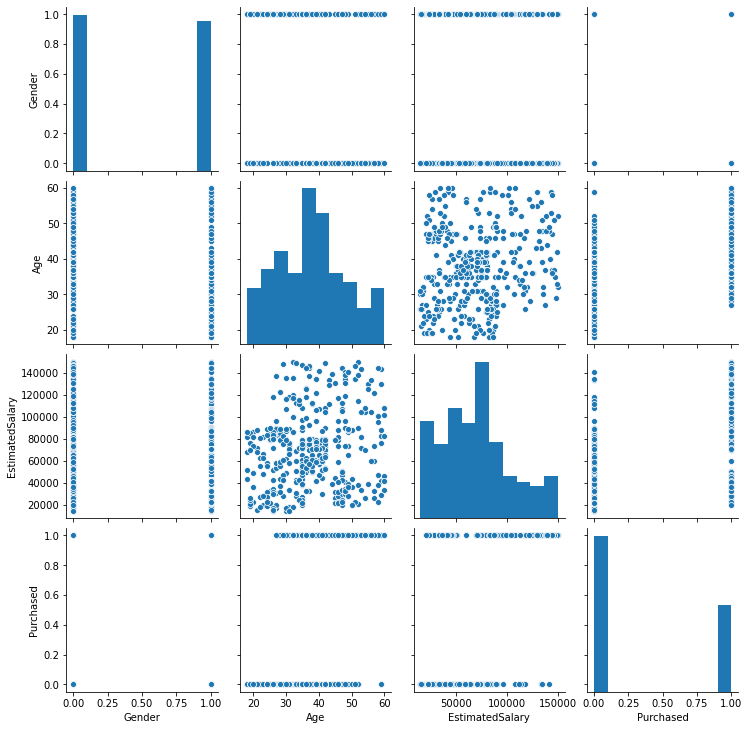

In [11]:
# Exploratory data analytics
plt.figure(figsize=(10, 10))
sns.pairplot(dataset)
plt.show()

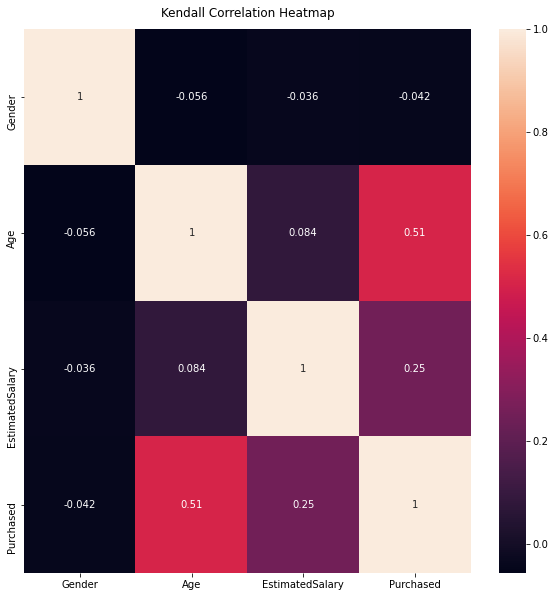

In [12]:
# Draw the correlation heatmaps using seaborn
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(dataset.corr(method='kendall'), annot=True)
heatmap.set_title('Kendall Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

# Get X and y, and then split the data

In [13]:
# Get X (independent variables) and y (dependent variable)
y_label = 'Purchased'
X = dataset.loc[:, dataset.columns != y_label]
display(pd.DataFrame(X))
y = dataset.loc[:, y_label]
display(pd.DataFrame(y))

,Gender,Age,EstimatedSalary
0,1,19,19000
1,1,35,20000
2,0,26,43000
3,0,27,57000
4,1,19,76000
...,...,...,...
395,0,46,41000
396,1,51,23000
397,0,50,20000
398,1,36,33000


,Purchased
0,0
1,0
2,0
3,0
4,0
...,...
395,1
396,1
397,1
398,0


In [14]:
my_test_size = 0.25
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=my_test_size, shuffle=False)
X_train.describe()

,Gender,Age,EstimatedSalary
count,300.000000,300.000000,300.000000
mean,0.496667,35.133333,69490.000000
std,0.500824,10.166945,34629.572009
min,0.000000,18.000000,15000.000000
25%,0.000000,27.000000,43000.000000
50%,0.000000,35.000000,70500.000000
75%,1.000000,41.000000,88000.000000
max,1.000000,60.000000,150000.000000


In [15]:
#Feature standardizing of X
from sklearn.preprocessing import StandardScaler
X_test = sc_X.transform(X_test)

In [16]:
#Get the original X_test
X_test_orig = sc_X.inverse_transform(X_test)
display(pd.DataFrame(X_test_orig))

,0,1,2
0,0.0,58.0,38000.0
1,1.0,48.0,74000.0
2,0.0,37.0,137000.0
3,1.0,37.0,79000.0
4,0.0,40.0,60000.0
...,...,...,...
95,0.0,46.0,41000.0
96,1.0,51.0,23000.0
97,0.0,50.0,20000.0
98,1.0,36.0,33000.0


# Create Dataframes for Evaluation

In [17]:
# included methods/models and metrics
methods = ['Logistic Regression', 'KNN', 'Linear SVM', 'Kernel SVM', 'Naive Bayes', 'Decision Tree', 'Random Forest', 'XGBoost', 'ANN']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 score', 'ROC AUC']

# create model quality dataframe
quality_df = pd.DataFrame(columns = metrics, index = methods)
display(quality_df)

# create model quality cross validation dataframe
quality_cv_df = pd.DataFrame(columns = metrics, index = methods)
display(quality_cv_df)

,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,NaN,NaN,NaN,NaN,NaN
KNN,NaN,NaN,NaN,NaN,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,NaN,NaN,NaN,NaN,NaN
KNN,NaN,NaN,NaN,NaN,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


# Logistic Regression

In [18]:
# Fit the model
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [19]:
#Predicting test set result
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,1
1,1
2,1
3,0
4,0
...,...
95,0
96,0
97,0
98,0


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.75,0.95122,0.629032,0.757282,0.7882
KNN,NaN,NaN,NaN,NaN,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867333,0.862676,0.872821,0.866369,0.943979
KNN,NaN,NaN,NaN,NaN,NaN
Linear SVM,NaN,NaN,NaN,NaN,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


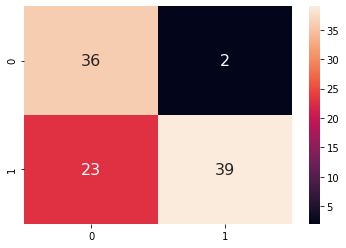

In [20]:
# Evaluate the model
method = 'Logistic Regression'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method)
display(quality_cv_df)

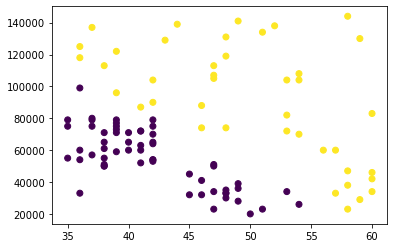

In [21]:
plt.scatter(X_test_orig[:,1],X_test_orig[:,2],c=y_pred)
plt.show()

# KNN

In [22]:
# Fit the model
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 10, metric = 'euclidean')
classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=10)

In [23]:
#Predicting test set result
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,1
1,1
2,1
3,0
4,0
...,...
95,0
96,1
97,1
98,0


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.75,0.95122,0.629032,0.757282,0.7882
KNN,0.87,0.980392,0.806452,0.884956,0.890068
Linear SVM,NaN,NaN,NaN,NaN,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867333,0.862676,0.872821,0.866369,0.943979
KNN,0.931333,0.938907,0.921815,0.929793,0.983735
Linear SVM,NaN,NaN,NaN,NaN,NaN
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


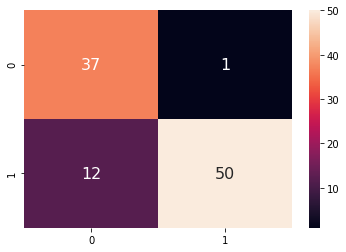

In [24]:
# Evaluate the model
method = 'KNN'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method)
display(quality_cv_df)

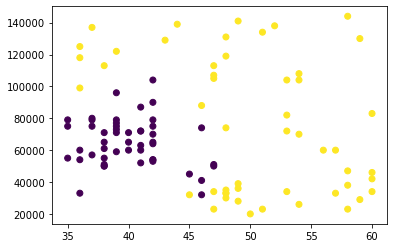

In [25]:
plt.scatter(X_test_orig[:,1],X_test_orig[:,2],c=y_pred)
plt.show()

# Linear SVM

In [26]:
# Fit the model
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', degree = 4, random_state = 0)
classifier.fit(X_train, y_train)


SVC(degree=4, kernel='linear', random_state=0)

In [27]:
#Predicting test set 
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,1
1,1
2,1
3,0
4,0
...,...
95,0
96,0
97,0
98,0


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.75,0.95122,0.629032,0.757282,0.7882
KNN,0.87,0.980392,0.806452,0.884956,0.890068
Linear SVM,0.75,0.95122,0.629032,0.757282,0.7882
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867333,0.862676,0.872821,0.866369,0.943979
KNN,0.931333,0.938907,0.921815,0.929793,0.983735
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Kernel SVM,NaN,NaN,NaN,NaN,NaN
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


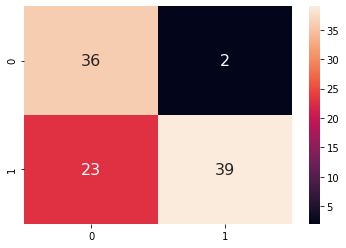

In [28]:
# Evaluate the model
method = 'Linear SVM'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method)
display(quality_cv_df)

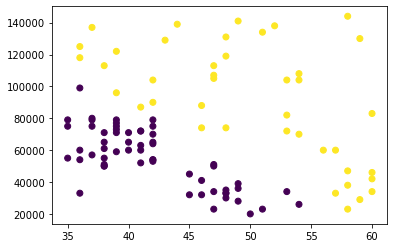

In [29]:
plt.scatter(X_test_orig[:,1],X_test_orig[:,2],c=y_pred)
plt.show()

# Kernel SVM

In [30]:
# Fit the model
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf',  random_state = 0)
classifier.fit(X_train, y_train)

SVC(random_state=0)

In [31]:
#Predict the test set 
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,1
1,1
2,1
3,0
4,0
...,...
95,0
96,1
97,1
98,0


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.75,0.95122,0.629032,0.757282,0.7882
KNN,0.87,0.980392,0.806452,0.884956,0.890068
Linear SVM,0.75,0.95122,0.629032,0.757282,0.7882
Kernel SVM,0.9,0.981481,0.854839,0.913793,0.914261
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867333,0.862676,0.872821,0.866369,0.943979
KNN,0.931333,0.938907,0.921815,0.929793,0.983735
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Kernel SVM,0.953333,0.949693,0.957123,0.95297,0.989302
Naive Bayes,NaN,NaN,NaN,NaN,NaN
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


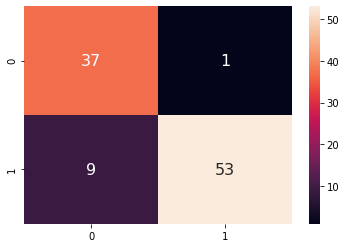

In [32]:
# Evaluate the model
method = 'Kernel SVM'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method)
display(quality_cv_df)

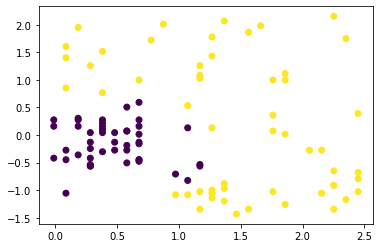

In [33]:
plt.scatter(X_test[:,1],X_test[:,2],c=y_pred)
plt.show()

# Naive Bayes

In [34]:
# Fit the model
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [35]:
#Predict the test set 
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,1
1,1
2,1
3,0
4,0
...,...
95,0
96,1
97,1
98,0


In [1]:
X_train

NameError: name 'X_train' is not defined

,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.75,0.95122,0.629032,0.757282,0.7882
KNN,0.87,0.980392,0.806452,0.884956,0.890068
Linear SVM,0.75,0.95122,0.629032,0.757282,0.7882
Kernel SVM,0.9,0.981481,0.854839,0.913793,0.914261
Naive Bayes,0.78,0.954545,0.677419,0.792453,0.812394
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867333,0.862676,0.872821,0.866369,0.943979
KNN,0.931333,0.938907,0.921815,0.929793,0.983735
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Kernel SVM,0.953333,0.949693,0.957123,0.95297,0.989302
Naive Bayes,0.830333,0.83568,0.818745,0.825881,0.917502
Decision Tree,NaN,NaN,NaN,NaN,NaN
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


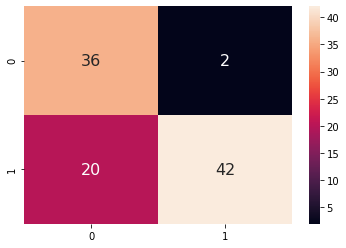

In [36]:
# Evaluate the model
method = 'Naive Bayes'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method)
display(quality_cv_df)

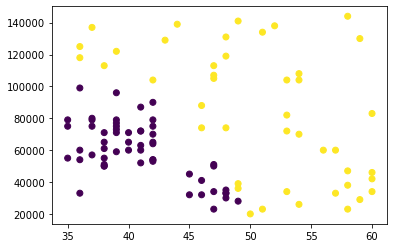

In [37]:
plt.scatter(X_test_orig[:,1],X_test_orig[:,2],c=y_pred)
plt.show()

# Decision Tree

In [38]:
# Fit the model
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0, min_samples_leaf = 10)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10, random_state=0)

In [39]:
#Predict the test set 
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,1
1,1
2,1
3,0
4,0
...,...
95,0
96,1
97,1
98,0


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.75,0.95122,0.629032,0.757282,0.7882
KNN,0.87,0.980392,0.806452,0.884956,0.890068
Linear SVM,0.75,0.95122,0.629032,0.757282,0.7882
Kernel SVM,0.9,0.981481,0.854839,0.913793,0.914261
Naive Bayes,0.78,0.954545,0.677419,0.792453,0.812394
Decision Tree,0.87,0.980392,0.806452,0.884956,0.890068
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867333,0.862676,0.872821,0.866369,0.943979
KNN,0.931333,0.938907,0.921815,0.929793,0.983735
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Kernel SVM,0.953333,0.949693,0.957123,0.95297,0.989302
Naive Bayes,0.830333,0.83568,0.818745,0.825881,0.917502
Decision Tree,0.807333,0.80631,0.809065,0.80575,0.869271
Random Forest,NaN,NaN,NaN,NaN,NaN
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


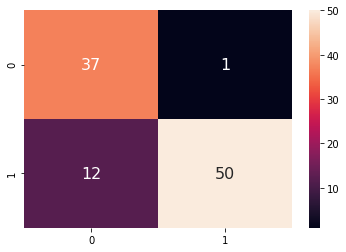

In [40]:
# Evaluate the model
method = 'Decision Tree'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method)
display(quality_cv_df)

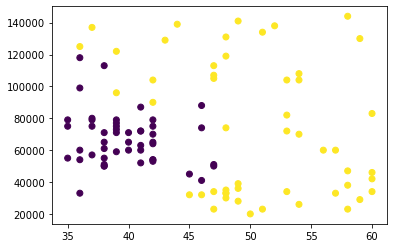

In [41]:
plt.scatter(X_test_orig[:,1],X_test_orig[:,2],c=y_pred)
plt.show()

# Random Forest

In [42]:
# Fit the model
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, oob_score=True, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', oob_score=True, random_state=0)

In [43]:
#Predict the test set 
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,1
1,0
2,1
3,0
4,0
...,...
95,0
96,1
97,1
98,0


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.75,0.95122,0.629032,0.757282,0.7882
KNN,0.87,0.980392,0.806452,0.884956,0.890068
Linear SVM,0.75,0.95122,0.629032,0.757282,0.7882
Kernel SVM,0.9,0.981481,0.854839,0.913793,0.914261
Naive Bayes,0.78,0.954545,0.677419,0.792453,0.812394
Decision Tree,0.87,0.980392,0.806452,0.884956,0.890068
Random Forest,0.84,0.925926,0.806452,0.862069,0.850594
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867333,0.862676,0.872821,0.866369,0.943979
KNN,0.931333,0.938907,0.921815,0.929793,0.983735
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Kernel SVM,0.953333,0.949693,0.957123,0.95297,0.989302
Naive Bayes,0.830333,0.83568,0.818745,0.825881,0.917502
Decision Tree,0.807333,0.80631,0.809065,0.80575,0.869271
Random Forest,0.916,0.915726,0.914331,0.91436,0.976928
XGBoost,NaN,NaN,NaN,NaN,NaN
ANN,NaN,NaN,NaN,NaN,NaN


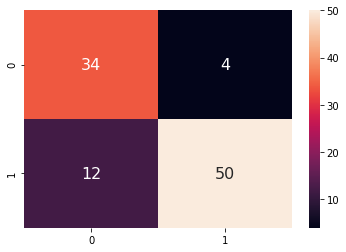

In [44]:
# Evaluate the model
method = 'Random Forest'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method)
display(quality_cv_df)

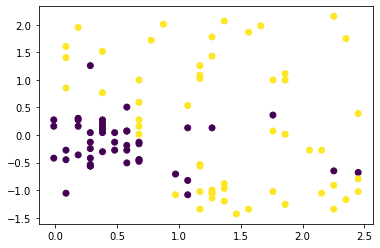

In [45]:
plt.scatter(X_test[:,1],X_test[:,2],c=y_pred)
plt.show()

# XGBoost

In [46]:
# Fit the model
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

[19:08:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [47]:
#Predict the test set 
y_pred = classifier.predict(X_test)
display(pd.DataFrame(y_pred))

,0
0,1
1,0
2,1
3,0
4,0
...,...
95,0
96,1
97,1
98,0


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.75,0.95122,0.629032,0.757282,0.7882
KNN,0.87,0.980392,0.806452,0.884956,0.890068
Linear SVM,0.75,0.95122,0.629032,0.757282,0.7882
Kernel SVM,0.9,0.981481,0.854839,0.913793,0.914261
Naive Bayes,0.78,0.954545,0.677419,0.792453,0.812394
Decision Tree,0.87,0.980392,0.806452,0.884956,0.890068
Random Forest,0.84,0.925926,0.806452,0.862069,0.850594
XGBoost,0.81,0.921569,0.758065,0.831858,0.826401
ANN,NaN,NaN,NaN,NaN,NaN


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.867333,0.862676,0.872821,0.866369,0.943979
KNN,0.931333,0.938907,0.921815,0.929793,0.983735
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Kernel SVM,0.953333,0.949693,0.957123,0.95297,0.989302
Naive Bayes,0.830333,0.83568,0.818745,0.825881,0.917502
Decision Tree,0.807333,0.80631,0.809065,0.80575,0.869271
Random Forest,0.916,0.915726,0.914331,0.91436,0.976928
XGBoost,0.929,0.924777,0.93345,0.928631,0.983523
ANN,NaN,NaN,NaN,NaN,NaN


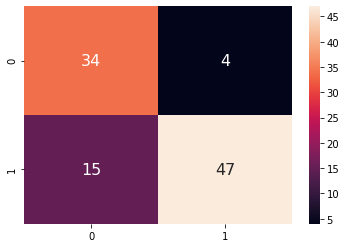

In [48]:
# Evaluate the model
method = 'XGBoost'
calculate_metrics(quality_df, method)
display(quality_df)
calculate_cv(quality_cv_df, classifier, method)
display(quality_cv_df)

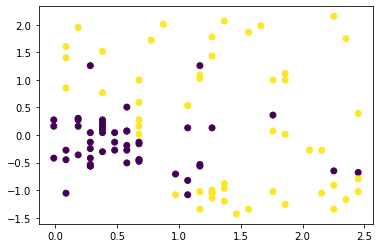

In [49]:
plt.scatter(X_test[:,1],X_test[:,2],c=y_pred)
plt.show()

# ANN

In [50]:
#Make an ANN
from keras.models import Sequential
from keras.layers import Dense

train_dim = X_train.shape[1]

#Initialie ANN
classifier = Sequential()

#Adding input layer and hidden layer, init = initialization of weight
classifier.add(Dense(2, activation = 'relu', input_dim = train_dim))

#Adding output layer
classifier.add(Dense(1, activation = 'sigmoid'))

#compile ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

#Fitting ANN to training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 20)

Epoch 1/20
30/30 [==============================] - 0s 765us/step - loss: 0.7250 - accuracy: 0.6633
Epoch 2/20
30/30 [==============================] - 0s 698us/step - loss: 0.7039 - accuracy: 0.7133
Epoch 3/20
30/30 [==============================] - 0s 665us/step - loss: 0.6865 - accuracy: 0.7300
Epoch 4/20
30/30 [==============================] - 0s 665us/step - loss: 0.6704 - accuracy: 0.7300
Epoch 5/20
30/30 [==============================] - 0s 650us/step - loss: 0.6565 - accuracy: 0.7300
Epoch 6/20
30/30 [==============================] - 0s 632us/step - loss: 0.6434 - accuracy: 0.7300
Epoch 7/20
30/30 [==============================] - 0s 731us/step - loss: 0.6323 - accuracy: 0.7300
Epoch 8/20
30/30 [==============================] - 0s 765us/step - loss: 0.6213 - accuracy: 0.7300
Epoch 9/20
30/30 [==============================] - 0s 632us/step - loss: 0.6113 - accuracy: 0.7300
Epoch 10/20
30/30 [==============================] - 0s 765us/step - loss: 0.6019 - accuracy: 0.7300

In [51]:
y_hat= classifier.predict(X_test)
y_pred = (y_hat > 0.5)
display(pd.DataFrame(y_pred))

,0
0,False
1,False
2,False
3,False
4,False
...,...
95,False
96,False
97,False
98,False


,Accuracy,Precision,Recall,F1 score,ROC AUC
Logistic Regression,0.75,0.95122,0.629032,0.757282,0.7882
KNN,0.87,0.980392,0.806452,0.884956,0.890068
Linear SVM,0.75,0.95122,0.629032,0.757282,0.7882
Kernel SVM,0.9,0.981481,0.854839,0.913793,0.914261
Naive Bayes,0.78,0.954545,0.677419,0.792453,0.812394
Decision Tree,0.87,0.980392,0.806452,0.884956,0.890068
Random Forest,0.84,0.925926,0.806452,0.862069,0.850594
XGBoost,0.81,0.921569,0.758065,0.831858,0.826401
ANN,0.45,0.888889,0.129032,0.225352,0.551358


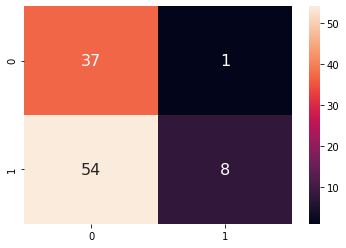

In [52]:
# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, annot_kws={"size": 16})
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
quality_df.loc['ANN'] = [accuracy, precision, recall, f1, auc]
quality_df

# Comparison

In [53]:
quality_df.sort_values(by=['Accuracy'], inplace=True, ascending=False)
quality_df

,Accuracy,Precision,Recall,F1 score,ROC AUC
Kernel SVM,0.9,0.981481,0.854839,0.913793,0.914261
KNN,0.87,0.980392,0.806452,0.884956,0.890068
Decision Tree,0.87,0.980392,0.806452,0.884956,0.890068
Random Forest,0.84,0.925926,0.806452,0.862069,0.850594
XGBoost,0.81,0.921569,0.758065,0.831858,0.826401
Naive Bayes,0.78,0.954545,0.677419,0.792453,0.812394
Logistic Regression,0.75,0.95122,0.629032,0.757282,0.7882
Linear SVM,0.75,0.95122,0.629032,0.757282,0.7882
ANN,0.45,0.888889,0.129032,0.225352,0.551358


In [54]:
quality_cv_df.sort_values(by=['Accuracy'], inplace=True, ascending=False)
quality_cv_df

,Accuracy,Precision,Recall,F1 score,ROC AUC
Kernel SVM,0.953333,0.949693,0.957123,0.95297,0.989302
KNN,0.931333,0.938907,0.921815,0.929793,0.983735
XGBoost,0.929,0.924777,0.93345,0.928631,0.983523
Random Forest,0.916,0.915726,0.914331,0.91436,0.976928
Linear SVM,0.87,0.864082,0.876537,0.869117,0.941471
Logistic Regression,0.867333,0.862676,0.872821,0.866369,0.943979
Naive Bayes,0.830333,0.83568,0.818745,0.825881,0.917502
Decision Tree,0.807333,0.80631,0.809065,0.80575,0.869271
ANN,NaN,NaN,NaN,NaN,NaN
